# Niral Shah
## ML HW 3


# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

* Go through an implementation of decision trees.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

*This file is adapted from course material by Carlos Guestrin and Emily Fox.*

Let's get started!

## Import some libraries

In [1]:
## please make sure that the packages are updated to the newest version. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Getting the data ready

We will be using a subset of the [LendingClub](https://www.kaggle.com/wendykan/lending-club-loan-data) dataset.

In [2]:
loans = pd.read_csv('loan_small.csv')

### Recoding the target column

We re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan. In the next cell, the features are also briefly explained. 

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]

loans['safe_loans'] = loans['loan_status'].apply(lambda x : +1 if x=='Fully Paid' else -1)

## please update pandas to the newest version in order to execute the following line
loans.drop(columns=['loan_status'], inplace=True)

target = 'safe_loans' # this variable will be used later

### Transform categorical data into binary features

In this assignment, we will work with **binary decision trees**. Since all of our features are currently categorical features, we want to turn them into binary features using 1-hot encoding. 

We can do so with the following code block:

In [4]:
loans = pd.get_dummies(loans)

Let's see what the feature columns look like now:

In [5]:
features = list(loans.columns)
features.remove('safe_loans')  # Remove the response variable
features

['term_ 36 months',
 'term_ 60 months',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year']

### Train-test split

We split the data into training and test sets with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(loans, test_size = 0.2, random_state=1)

# Weighted decision trees

Since the data weights change as we build an AdaBoost model, we need to first code a decision tree that supports weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight. We have provided a skeleton for you with `YOUR CODE HERE` to be filled in several places.

In [17]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistake_all_neg = total_weight_positive
#     print weighted_mistake_all_neg
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistake_all_pos = total_weight_negative
#     print weighted_mistake_all_pos
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if(weighted_mistake_all_neg<weighted_mistake_all_pos):
        return (weighted_mistake_all_neg,-1)
    else:
        return (weighted_mistake_all_pos,+1)

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function, run the following cell:

In [18]:
example_labels = pd.Series([-1, -1, 1, 1, 1])
example_data_weights = pd.Series([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$


### Function to pick best feature to split on

The next step is to pick the best feature to split on.

The **best_splitting_feature** function takes the data, the festures, the targetm and the data weights as input and returns the best feature to split on.
  
Complete the following function.

In [43]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature]==0]
        right_data_weights = data_weights[data[feature]==1]
        
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        labels = data[target]
        left_labels = labels[data[feature] == 0]
        right_labels = labels[data[feature] == 1]
        WM_left, llabel = intermediate_node_weighted_mistakes(left_labels, left_data_weights)
        WM_right, rlabel = intermediate_node_weighted_mistakes(right_labels, right_data_weights)
        
        
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
    
        error = (WM_left+WM_right)/float(sum(data_weights))
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

**Checkpoint:** Now, we have another checkpoint to make sure you are on the right track.

In [44]:
example_data_weights = np.array(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


**Aside**. Relationship between weighted error and weight of mistakes:

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}] + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
We then divide through by the total weight of all data points to obtain $\mathrm{E}({\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}({\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}({\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}({\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. A decision tree will be represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [45]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    ## YOUR CODE HERE
    leaf['prediction'] = best_class
    
    return leaf 

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [51]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    ## YOUR CODE HERE
    current_depth +=1;
    left_tree = weighted_decision_tree_create(left_split,remaining_features,target, left_data_weights,current_depth,max_depth)
    right_tree = weighted_decision_tree_create(right_split,remaining_features,target, right_data_weights,current_depth,max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a recursive function to count the nodes in your tree:

In [52]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [53]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature term_ 36 months. (8850, 23150)
--------------------------------------------------------------------
Subtree, depth = 2 (8850 data points).
Split on feature grade_A. (8775, 75)
--------------------------------------------------------------------
Subtree, depth = 3 (8775 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (75 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (23150 data points).
Split on feature grade_D. (19331, 3819)
--------------------------------------------------------------------
Subtree, depth = 3 (19331 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (3819 data poin

Let us take a quick look at what the trained tree is like. You should get something that looks like the following

```
{'is_leaf': False,
    'left': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'splitting_feature': 'grade_A'
     },
    'prediction': None,
    'right': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'splitting_feature': 'grade_D'
     },
     'splitting_feature': 'term. 36 months'
}```

In [44]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'term_ 36 months'}

### Making predictions with a weighted decision tree

We give you a function that classifies one data point. It can also return the probability if you want to play around with that as well.

In [54]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (a dataframe)

The function does not change because of adding data point weights.

In [55]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    # YOUR CODE HERE
    
    prediction = data.apply(lambda x:classify(tree,x),axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [56]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.390875

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [57]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature emp_length_10+ years. (22413, 9587)
--------------------------------------------------------------------
Subtree, depth = 2 (22413 data points).
Split on feature grade_A. (19673, 2740)
--------------------------------------------------------------------
Subtree, depth = 3 (19673 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (2740 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (9587 data points).
Stopping condition 1 reached.


Now, we will compute the classification error on the `subset_20`, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [58]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.15

Now, let us compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [59]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.445625

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture notes the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**. Fill in the places with `YOUR CODE HERE`.

In [80]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data (uniformly weighted)
    alpha =  np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        # YOUR CODE HERE
        tree_stumps.append(weighted_decision_tree_create(data,features,target,data_weights=alpha,max_depth=1))
        
        # Make predictions
        ## YOUR CODE HERE
        predictions = data.apply(lambda x: classify(tree_stumps[t],x),axis=1)
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        ## YOUR CODE HERE
        weighted_error = sum(alpha[is_wrong])/float(sum(alpha))
        
        # Compute model coefficient using weighted error
        ## YOUR CODE HERE
        weight = 0.5*np.log((1-weighted_error)/weighted_error)
        weights.append(weight) 
        
        # Adjust weights on data point
        ## YOUR CODE HERE
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = alpha*adjustment
        alpha /= sum(alpha)
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [81]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature term_ 36 months. (8850, 23150)
--------------------------------------------------------------------
Subtree, depth = 2 (8850 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (23150 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature grade_A. (28081, 3919)
--------------------------------------------------------------------
Subtree, depth = 2 (28081 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3919 data points).
Reached maximum depth. Stopping for now.


In [82]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('_')
    print '                       root'
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

Here is what the first stump looks like:

In [83]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [84]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [85]:
print stump_weights

[0.17198848113764034, 0.1772878063726963]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.17, 0.18]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [86]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature term_ 36 months. (8850, 23150)
--------------------------------------------------------------------
Subtree, depth = 2 (8850 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (23150 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature grade_A. (28081, 3919)
--------------------------------------------------------------------
Subtree, depth = 2 (28081 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3919 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [95]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis = 1)
        
        # Accumulate predictions on scaores array
        # YOUR CODE HERE
        scores = scores + stump_weights[i]*predictions
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [96]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_data[target], predictions)
print 'Accuracy of 10-component ensemble = %s' % accuracy 

Accuracy of 10-component ensemble = 0.62825


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [97]:
stump_weights

[0.17198848113764034,
 0.1772878063726963,
 0.10308067697010909,
 0.08686702058336851,
 0.07220085937793974,
 0.07438562925258671,
 0.05834552873244469,
 0.04545487026475097,
 0.0319454846001187,
 0.023305292432239024]

**Question** i: Are the weights monotonically decreasing, monotonically increasing, or neither?

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

**Answer:** The weights appear to be monotonically decreasing. 

# Performance plots

In this section, we will try to reproduce some performance plots.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [98]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature term_ 36 months. (8850, 23150)
--------------------------------------------------------------------
Subtree, depth = 2 (8850 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (23150 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (32000 data points).
Split on feature grade_A. (28081, 3919)
--------------------------------------------------------------------
Subtree, depth = 2 (28081 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3919 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [99]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - accuracy_score(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.41484374999999996
Iteration 2, training error = 0.43281250000000004
Iteration 3, training error = 0.39059374999999996
Iteration 4, training error = 0.39059374999999996
Iteration 5, training error = 0.37931250000000005
Iteration 6, training error = 0.38228125
Iteration 7, training error = 0.37253125
Iteration 8, training error = 0.37549999999999994
Iteration 9, training error = 0.37253125
Iteration 10, training error = 0.37253125
Iteration 11, training error = 0.37253125
Iteration 12, training error = 0.37150000000000005
Iteration 13, training error = 0.37253125
Iteration 14, training error = 0.37150000000000005
Iteration 15, training error = 0.37150000000000005
Iteration 16, training error = 0.37150000000000005
Iteration 17, training error = 0.37150000000000005
Iteration 18, training error = 0.37146875
Iteration 19, training error = 0.37150000000000005
Iteration 20, training error = 0.37146875
Iteration 21, training error = 0.37209375
Iteration 22, train

### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

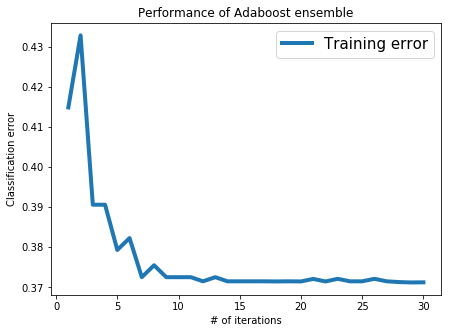

In [100]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

In [101]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - accuracy_score(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.41037500000000005
Iteration 2, test error = 0.43174999999999997
Iteration 3, test error = 0.390875
Iteration 4, test error = 0.390875
Iteration 5, test error = 0.37825
Iteration 6, test error = 0.382625
Iteration 7, test error = 0.37175
Iteration 8, test error = 0.37612500000000004
Iteration 9, test error = 0.37175
Iteration 10, test error = 0.37175
Iteration 11, test error = 0.37175
Iteration 12, test error = 0.369375
Iteration 13, test error = 0.369375
Iteration 14, test error = 0.369375
Iteration 15, test error = 0.369375
Iteration 16, test error = 0.369375
Iteration 17, test error = 0.369375
Iteration 18, test error = 0.371
Iteration 19, test error = 0.369375
Iteration 20, test error = 0.371
Iteration 21, test error = 0.36924999999999997
Iteration 22, test error = 0.371
Iteration 23, test error = 0.367625
Iteration 24, test error = 0.369375
Iteration 25, test error = 0.369375
Iteration 26, test error = 0.367625
Iteration 27, test error = 0.369375
Iterati

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

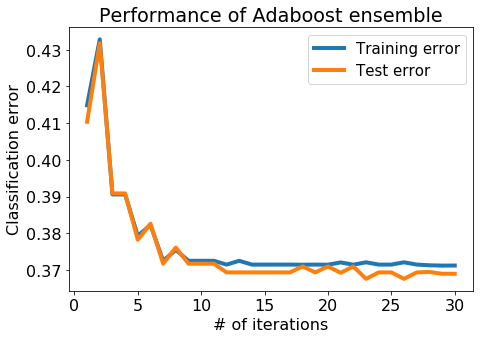

In [102]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

**Question** ii: From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?

** Answer :** The fit improves, with some minor overfitting occuring at earlier iterations, but the fit improves well to the point that there is no overfitting occuring at all as the number of iterations increases. 